# Problem Statement

* The goal is to predict the type of dry beans from a dataset consisting of features extracted from beans images using computer vision.

For more information, refer to the following [link.](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset)
​
## **Data fields:**
1. **ID**, an ID for this instance.
2. **Area - (A)**, The area of a bean zone and the number of pixels within its boundaries.
3. **Perimeter - (P)**, Bean circumference is defined as the length of its border.
4. **MajorAxisLength - (L)**, The distance between the ends of the longest line that can be drawn from a bean.
5. **MinorAxisLength - (l)**, The longest line that can be drawn from the bean while standing perpendicular to the main axis.
6. **AspectRatio - (K)**, Defines the relationship between L and l : $K = \frac{L}{l}$
7. **Eccentricity - (Ec)**, Eccentricity of the ellipse having the same moments as the region.
8. **ConvexArea - (C)**, Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
9. **EquivDiameter - (Ed)**, The diameter of a circle having the same area as a bean seed area: $E_{d} = \sqrt{\frac{4A}{\pi}}$
10. **Extent - (Ex)**, The ratio of the pixels in the bounding box to the bean area $Ex = \frac{A}{A_{B}}$ Where $A_{B} = $ Area of bounding rectangle.
11. **Solidity - (S)**, Also known as convexity. The ratio of the pixels in the convex shell to those found in beans: $S = \frac{A}{C}$
12. **Roundness - (R)**, Calculated with the following formula: $R = \frac{4\pi A}{P^2}$
13. **Compactness - (CO)**, Measures the roundness of an object: $CO = \frac{E_{d}}{L}$
14. **ShapeFactor1** - $(SF_{1})$ Calculated with the following formula: $SF_{1} = \frac{L}{A}$
15. **ShapeFactor2** - $(SF_{2})$ Calculated with the following formula: $SF_{2} = \frac{l}{A}$
16. **ShapeFactor3** - $(SF_{3})$ Calculated with the following formula: $SF_{3} = \frac{A}{\frac{L}{2}*\frac{L}{2}*\pi}$
17. **ShapeFactor4** - $(SF_{4})$ Calculated with the following formula: $SF_{4} = \frac{A}{\frac{L}{2}*\frac{l}{2}*\pi}$
18. **y**, the class of the bean. It can be any of ***BARBUNYA*, *SIRA*, *HOROZ*, *DERMASON*, *CALI*, *BOMBAY*, and *SEKER***.

In [52]:
import os
import csv

# Data Manipulation
import pandas as pd
import numpy as np
from scipy.constants import pi as PI

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline

# Load Data


In [53]:
# Loading Data
dataset_path = 'input/dry-beans-classification-iti-ai-pro-intake01'
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/dry-beans-classification-iti-ai-pro-intake01\submission.csv
input/dry-beans-classification-iti-ai-pro-intake01\test.csv
input/dry-beans-classification-iti-ai-pro-intake01\train.csv


In [54]:
data = pd.read_csv(os.path.join(dataset_path, 'train.csv'), encoding='utf8', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10834 entries, 0 to 10833
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             10834 non-null  int64  
 1   Perimeter        10834 non-null  float64
 2   MajorAxisLength  10834 non-null  float64
 3   MinorAxisLength  10834 non-null  float64
 4   AspectRation     10834 non-null  float64
 5   Eccentricity     10834 non-null  float64
 6   ConvexArea       10834 non-null  int64  
 7   EquivDiameter    10834 non-null  float64
 8   Extent           10834 non-null  float64
 9   Solidity         10834 non-null  float64
 10  roundness        10834 non-null  float64
 11  Compactness      10834 non-null  float64
 12  ShapeFactor1     10834 non-null  float64
 13  ShapeFactor2     10834 non-null  float64
 14  ShapeFactor3     10834 non-null  float64
 15  ShapeFactor4     10834 non-null  float64
 16  y                10834 non-null  object 
dtypes: float64(1

# EDA
## Target feature

The target feature is imbalanced, `DERMASON` being the most common class, while `BOMBAY` the most rare one, which could affect the model score if the classes are not easily seperable.

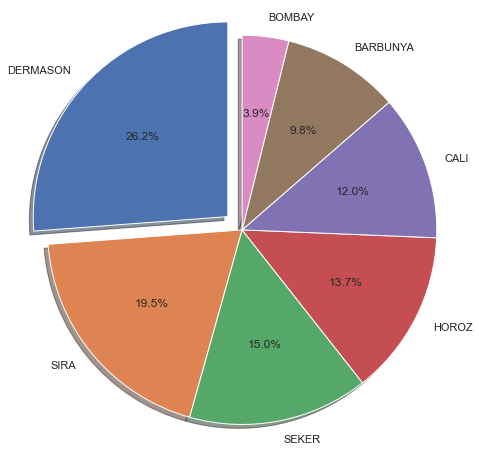

In [55]:
explode = [0.1] + [0] * 6
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(data.y.value_counts().values.tolist(), explode=explode, labels=data.y.value_counts().index.tolist(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  

plt.show()

# Univariate analysis
* Most features show skewness and outliers in their distributions, these points may resemble a unique class of dry beans.
* The distribution of each feature should be investegated with respect to the classes.

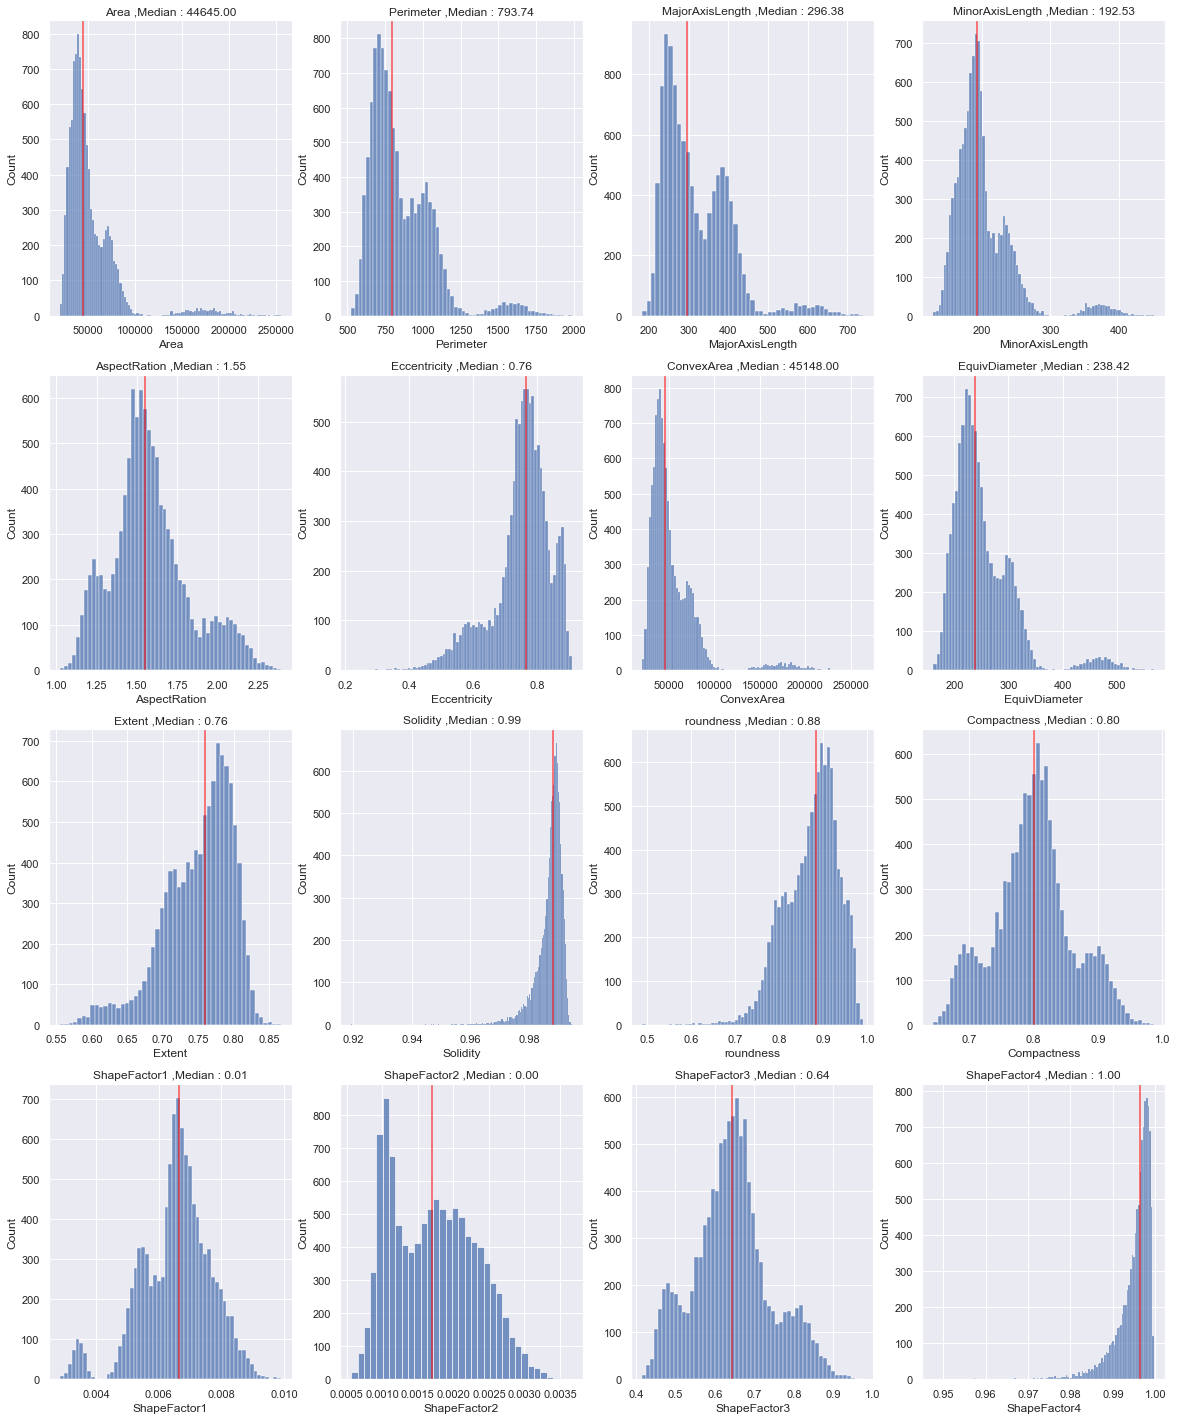

In [56]:
fig, axes = plt.subplots(4, 4, figsize=(20, 25))
for feature, ax in zip(data.columns.drop("y"), axes.flatten()):
    sns.histplot(data=data[feature],ax=ax)
    median = data[feature].median()
    ax.set_title( f'{feature} ,Median : {median:0.2f}')
    ax.axvline(median,
               color ='red', 
               lw=2, 
               alpha=0.5)
plt.show()

* The following features have a very skewed distribution with long tails: (`Eccentricity`, `Solidity`, `roundness`, `Shapefactor2`, `Shapefactor4`)
* `Bombay` class is easily separable from the other classes; it has larger `Area`, `Perimeter`, and can be clearly distinguished from other classes based on `MinorAxisLength` $>310$ and `ShapeFactor1` $<0.0041$.
* Both `Barbunya` class and `Cali` classes share similar distributions and values in the following feautures: (`Area`, `MinorAxisLength`, `EquivDiameter`, `Extent`, `ShapeFactor1`), which may lead to mislabeling one as the other.
* The class `Dermason` strongly overlaps with `Seker` and `Sira` classes which could make it difficult classify them accurately.

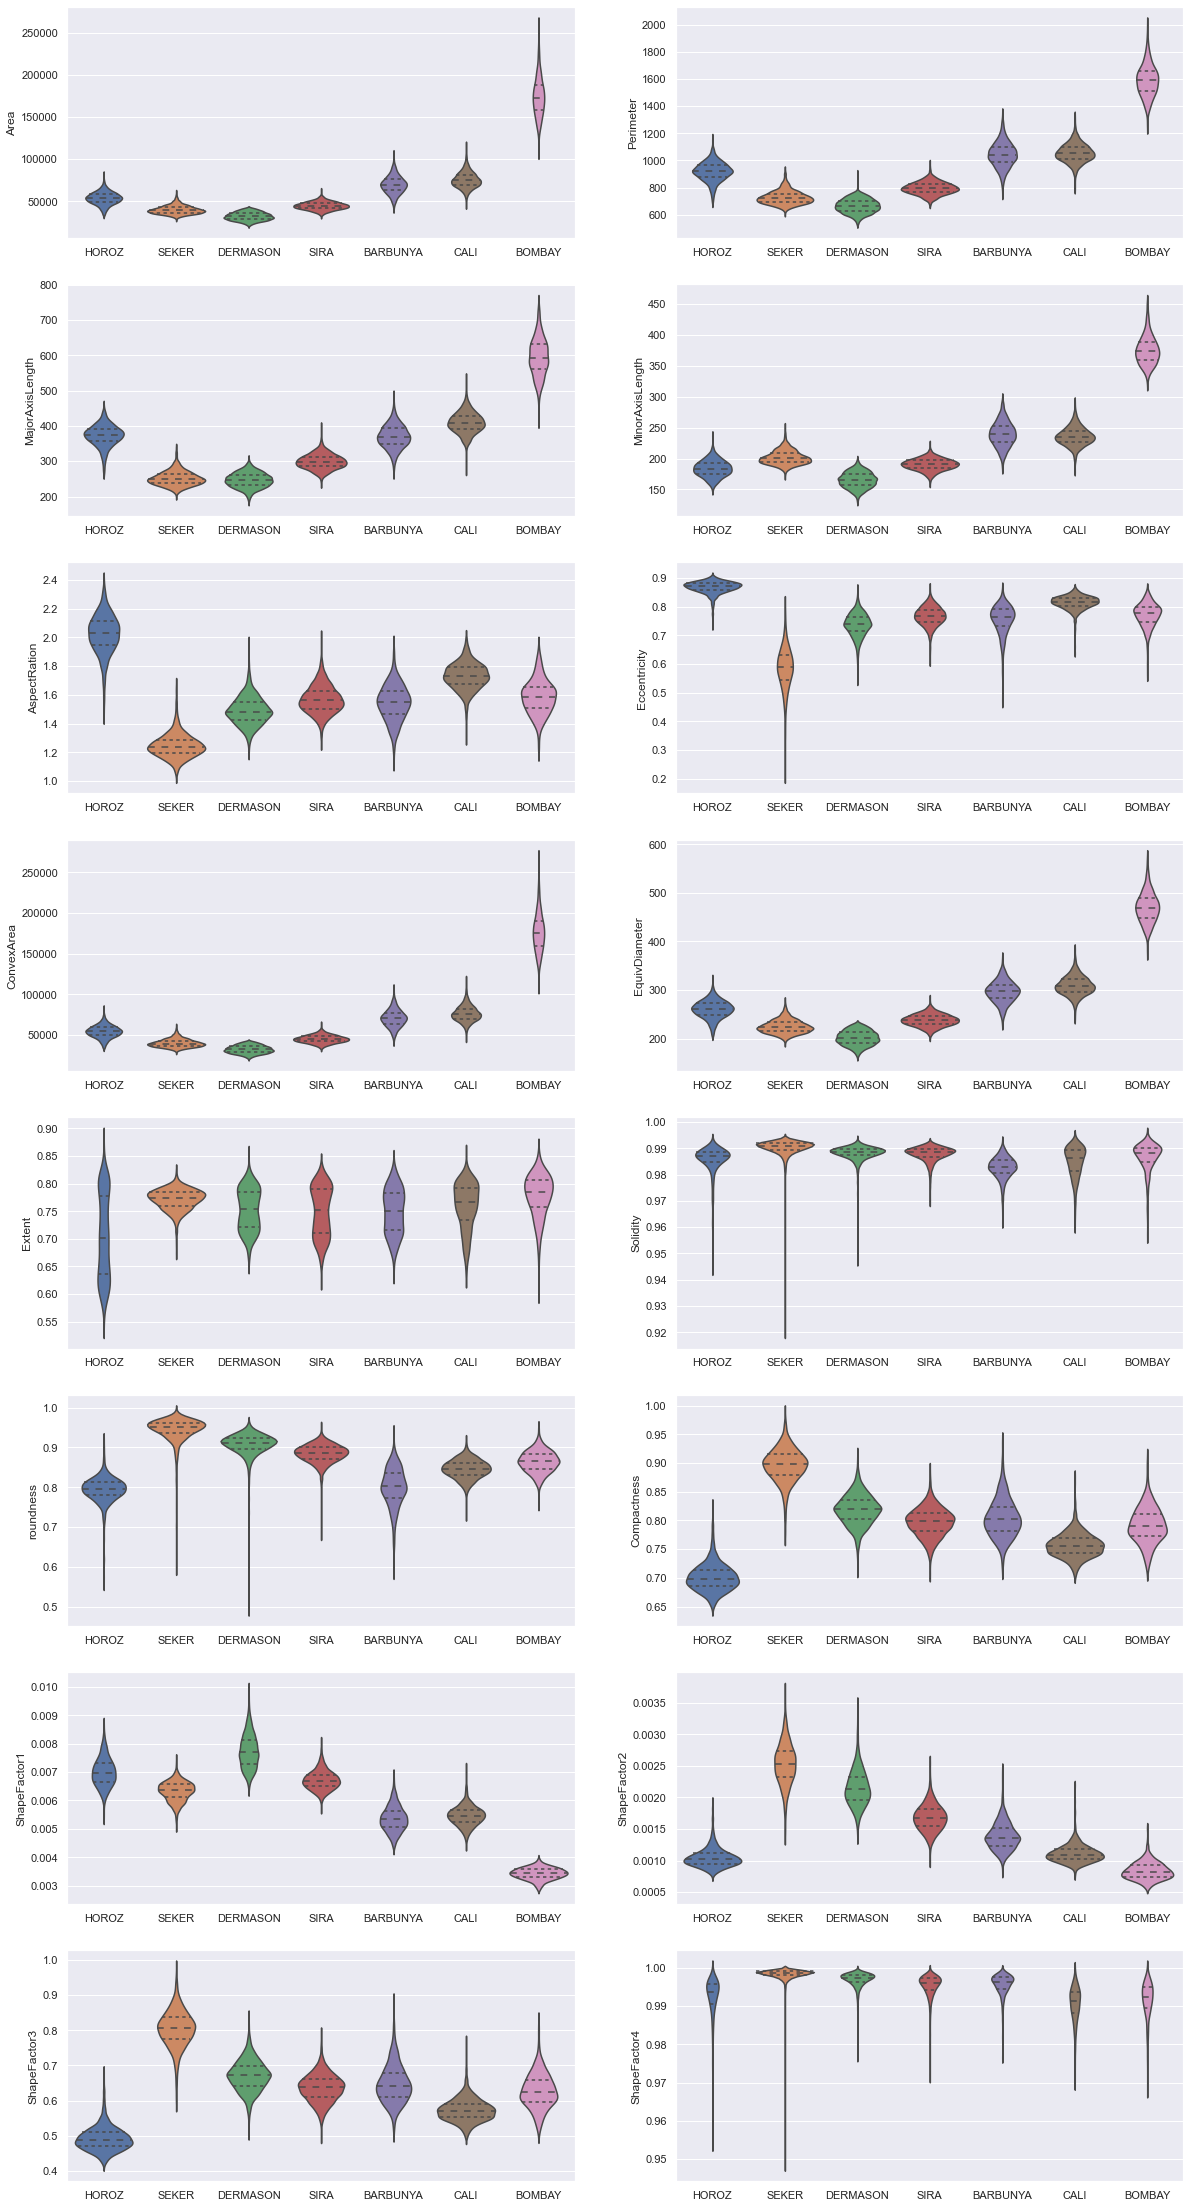

In [57]:
fig, axes = plt.subplots(8, 2, figsize = (20, 40))
for feature, ax in zip(data.columns.drop("y"), axes.flatten()):
    sns.violinplot(data=data,
                   x="y",
                   y=feature,
                   inner="quartile",
                   ax=ax)
    ax.set(xlabel=None)
plt.show()

# Multivariate Analysis
The heatmap shows strong linear correlations between many of the features, this redundancy may have an adverse effect on the model.

<AxesSubplot:>

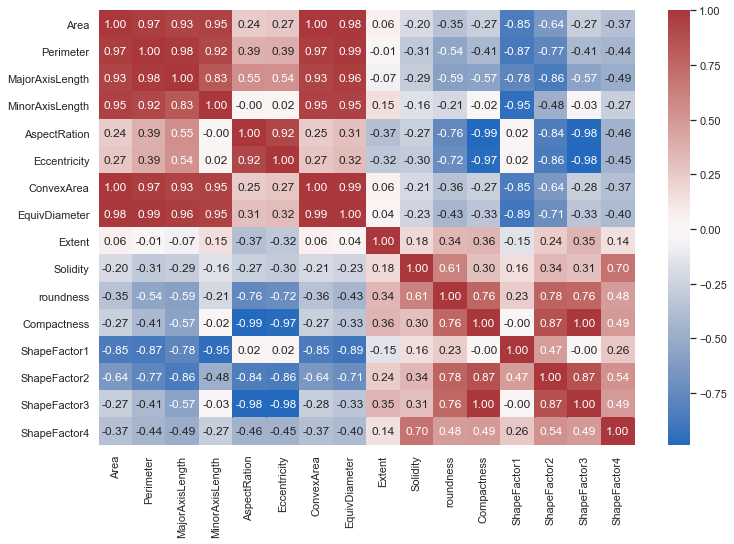

In [58]:
plt.figure(figsize = [12, 8])
sns.heatmap(data.corr(), annot=True, cmap='vlag', fmt='.2f')

Further investigation using the pairplot below shows that although the features are strongly correlated linearly, the variance in the target features cannot be accuratly explained using one variable, however, applying PCA to some of the features could reduce some of the noise and make the training process simpler.

The overlap between `SIRA`, `DERMASON` and `SIRA` is highlighted in most of the features.

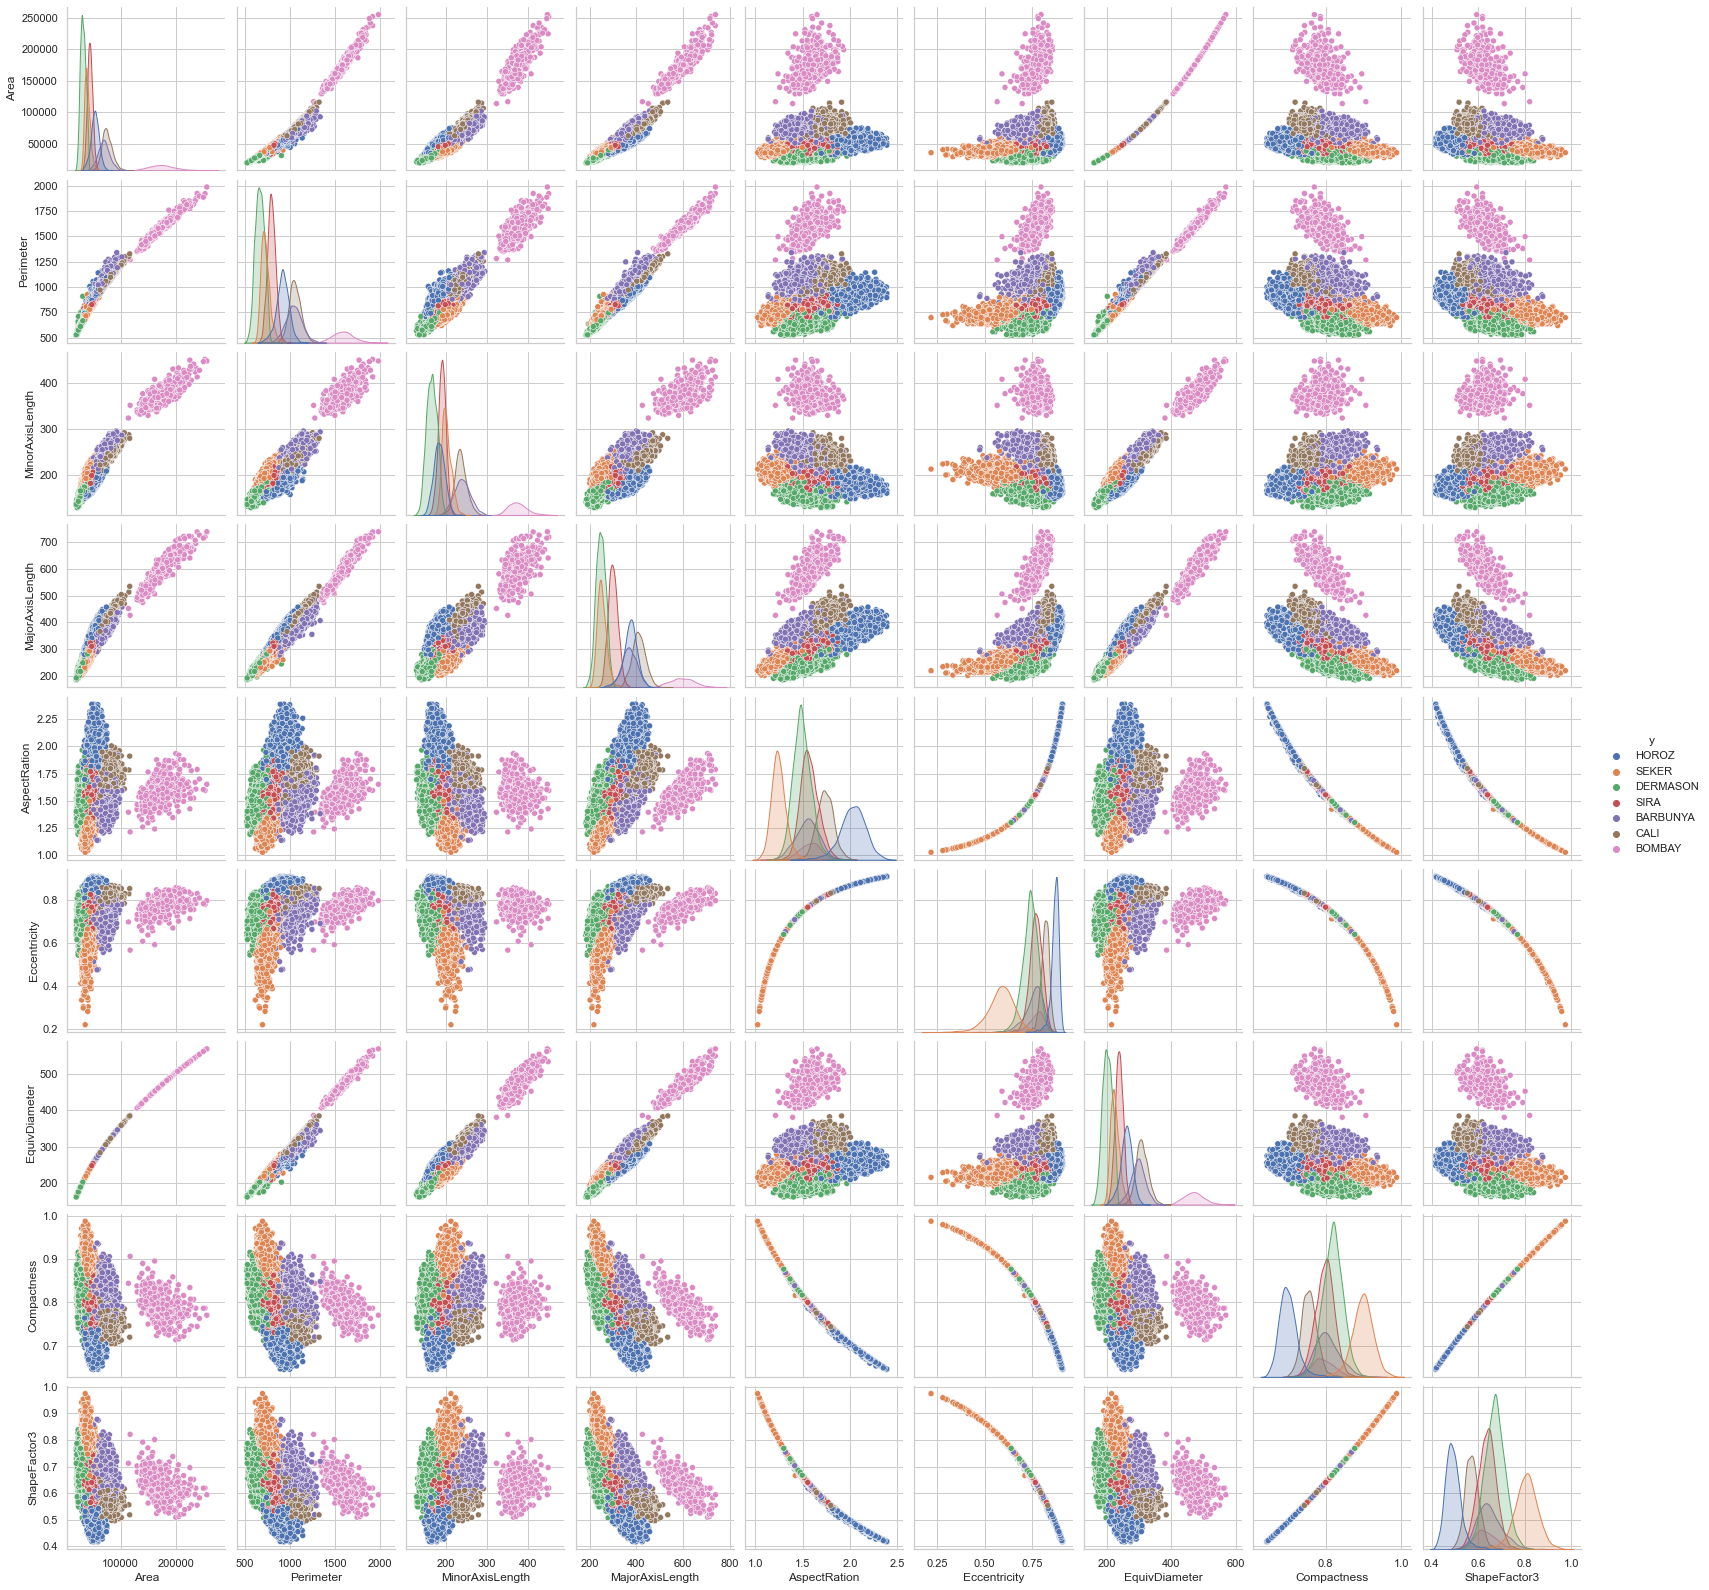

In [59]:
Strongly_corr_features = data[[
    "Area", "Perimeter",  
    'MinorAxisLength', 'MajorAxisLength',
    "AspectRation", "Eccentricity", 
    "EquivDiameter",  "Compactness", 
    'ShapeFactor3', "y"]]
Strongly_corr_features.head()
sns.set_theme(style="whitegrid")
sns.pairplot(Strongly_corr_features, hue="y")

## T-SNE Insights
### Overlap in classes
1. `SEKER` and `SIRA`
2. `HOROZ` and `CALI`
3. `DERMASON` and `SEKER`
4. `DERMASON` and `SIRA`
5. `BARBUNYA` and `CALI`

In [60]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42, n_jobs=-1, n_iter= 1000)
X_tsne = tsne.fit_transform(data.drop('y', axis=1))

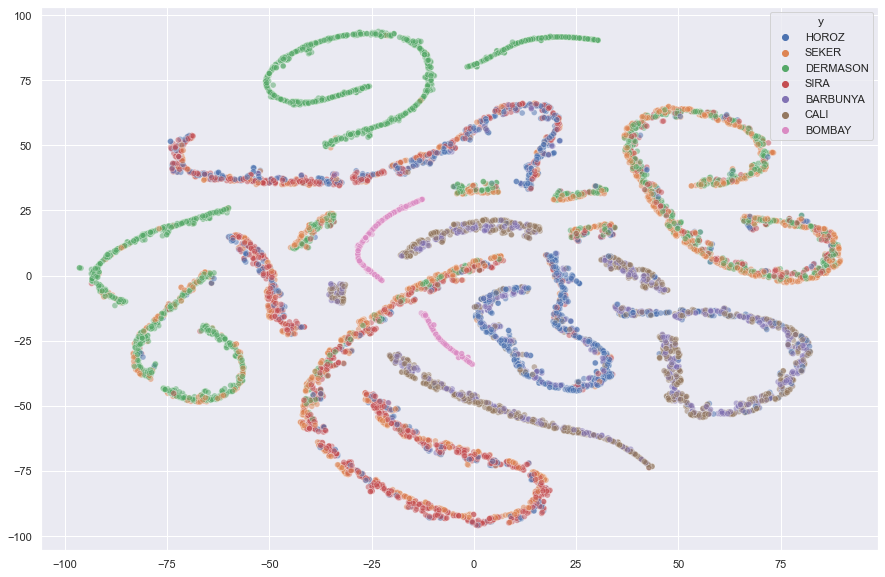

In [61]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue='y', alpha=0.5, data=data)

# Baseline model

In [62]:
encoder = LabelEncoder()
X = data.drop('y', axis=1).copy()
y = encoder.fit_transform(data.y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [63]:
print('Train: ', X_train.shape, y_train.shape)
print('Valid: ', X_valid.shape, y_valid.shape)

Train:  (8667, 16) (8667,)
Valid:  (2167, 16) (2167,)


In [64]:
from sklearn.svm import SVC
KERNEL = 'rbf'

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel=KERNEL, C=100, gamma=0.1))])

pipeline.fit(X_train, y_train)
print("Validation f1 score")
f1_score(y_valid, pipeline.predict(X_valid), average='micro')

Validation f1 score


0.9266266728195662

As was expected, the majority of misclassifications was between `DERAMSON` and `SIRA`, and `DERAMSON` and `SEKER`.

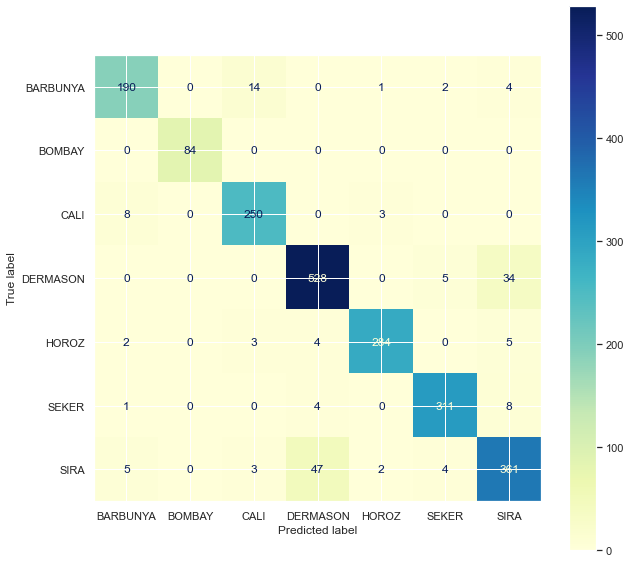

In [65]:
cm = confusion_matrix(y_valid, pipeline.predict(X_valid), labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.inverse_transform(pipeline.classes_))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='YlGnBu', ax=ax)

# Prepare Features
In order to increase the model's accuracy, some feature engineering is needed

In [77]:
def get_surface_area(a, b, c):
    return 4 * PI * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3) ** (1 / 1.6) 

def gen_features(X):
    X['Volume'] = X['Area'] * X["MajorAxisLength"] * X["ShapeFactor1"]
    X['Axis3'] = 3/4 * (X['Volume'] / (PI * X['MajorAxisLength'] * X['MinorAxisLength']))
    X['Area2'] = PI * X['MajorAxisLength'] * X['Axis3']
    X['oblong'] = X['Area'] / X['Volume']
    X['ShapeFactors_sum'] = X['ShapeFactor1'] + X['ShapeFactor2'] + X['ShapeFactor3'] + X['ShapeFactor4']
    X['Compactness'] = X['Compactness'] * X['EquivDiameter']

    return X.drop('ConvexArea', axis=1)


# Split and prepare Ddata

In [78]:
X = gen_features(data.drop('y', axis=1))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Parameters hypertuning

In [79]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval

KERNEL = 'rbf'
EARLY_STOP_ROUNDS = 50
def tune_params(model_choice, space):
    
    def score(params):
        if model_choice == 'xgb':
            model = XGBClassifier(**params, n_jobs=-1, random_state=42, verbosity=0, use_label_encoder=False)
            model.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=EARLY_STOP_ROUNDS)
        elif model_choice == 'cat':
            model = CatBoostClassifier(**params, verbose=False, eval_metric='TotalF1', random_state=42, leaf_estimation_iterations=1, thread_count=-1)
            model.fit(X_train, y_train, verbose=False)#, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=EARLY_STOP_ROUNDS)
        elif model_choice == 'svm':
            model = SVC(**params, kernel=KERNEL, random_state=42, n_jobs=-1).fit(X_train, y_train)
        elif model_choice == 'logit':
            model = LogisticRegression(**params, random_state=42, n_jobs=-1).fit(X_train, y_train)
        elif model_choice == 'knn':
            model = KNeighborsClassifier(**params, n_jobs=-1).fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        score = f1_score(y_valid, y_pred, average='micro')
        print(score)
        return {'loss': -score, 'status': STATUS_OK}    # Flip the sign of score to maximize it
        
    def optimize(trials, space):
        
        best = fmin(score, space, algo=tpe.suggest, max_evals=10)
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    return space_eval(space, best_params)

# Train model

## Catboost


In [80]:
space_cat = { 
    "learning_rate": hp.uniform('learning_rate', 0.01, 0.2),
    "max_depth": hp.choice('max_depth', np.arange(3, 10, 1)), 
    "n_estimators": hp.choice('n_estimators', np.arange(500, 1500, dtype=int)),
    "colsample_bylevel": hp.uniform('colsample_bylevel', 0.8, 1.0)
    }

# params_cat = tune_params(model_choice='cat', space=space_cat)
params_cat = {
    'colsample_bylevel': 0.8208192755223365,
    'learning_rate': 0.15070467787209785,
    'max_depth': 8,
    'n_estimators': 673}
    
cat_clf = CatBoostClassifier(**params_cat, verbose=False, eval_metric='TotalF1', leaf_estimation_iterations=1, thread_count=-1)
cat_clf.fit(X, y, verbose=False)#, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=EARLY_STOP_ROUNDS)
# print("Best tree limit: ", cat_clf.tree_count_)

## XGBoosts

In [81]:
from xgboost import XGBClassifier

# Model Parameters Hypertuning
space_xgb ={
    # 'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(500, 1500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 12, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    # 'subsample': hp.uniform('random_strength', 0.7, 1)
    }

# params_xgb = tune_params(model_choice='xgb', space=space_xgb)

# params_xgb = {
#     'colsample_bylevel': 0.8632770526919212,
#     'learning_rate': 0.11006762092656638,
#     'max_depth': 7,
#     'n_estimators': 2703}

params_xgb_2 = {
    'colsample_bylevel': 0.8632770526919212,
    'learning_rate': 0.11006762092656638,
    'max_depth': 7,
    'n_estimators': 69}

xgb_clf = XGBClassifier(verbosity=0, n_jobs=-1, **params_xgb_2, random_state=42, use_label_encoder=False)
xgb_clf.fit(X, y, verbose=False)#, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=EARLY_STOP_ROUNDS)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8632770526919212, colsample_bynode=1,
              colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.11006762092656638,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=69, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

## SVM

In [82]:
space_svc = {"C": hp.uniform('C', 0.5, 100), "gamma": hp.uniform('gamma', 0.01, 3)}

# params_svc = tune_params(model='svm', space=space_svc)
params_svc = {'C': 23.633068979286442, 'gamma': 0.05665681601640968}
svc_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel=KERNEL, **params_svc))])
svc_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=23.633068979286442, gamma=0.05665681601640968))])

## Logistic regression

In [83]:
space_logit = {"C": hp.uniform('C', 0.5, 100), "max_iter": hp.choice('max_iter', np.arange(500, 2000, 50))}

# params_logit = tune_params(model_choice='logit', space=space_logit)
params_logit = {'C': 48.218122657143105, 'max_iter': 800}
logit_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(**params_logit, random_state=42, n_jobs=-1))
])
logit_pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logit',
                 LogisticRegression(C=48.218122657143105, max_iter=800,
                                    n_jobs=-1, random_state=42))])

## KNN

In [84]:
space_knn = {"n_neighbors": hp.choice('n_neighbors', np.arange(2, 11, 1))}

# params_knn = tune_params(model_choice='knn', space=space_knn)
params_knn = {'n_neighbors': 3}
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(**params_knn, n_jobs=-1))
])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

## Ensemble


In [85]:
def predict_with_votes(X_test):
    y_preds = np.zeros(shape=(len(X_test), 4), dtype='int')
    y_preds[:, 0] = xgb_clf.predict(X_test)
    y_preds[:, 1] = cat_clf.predict(X_test).ravel()
    y_preds[:, 2] = svc_pipe.predict(X_test)
    y_preds[:, 3] = logit_pipe.predict(X_test)

    return (np.apply_along_axis(
        lambda x: np.bincount(x).argmax(), 
        axis=1, 
        arr=y_preds))

# Evaluate Model
## Validation

Through feature engineering and hyperparameter tuning the ensemble was able to raise the score from a baseline of `92%` to `96%`

In [86]:
print('Validation score:')
f1_score(y_valid, predict_with_votes(X_valid), average='micro')

Validation score:


0.9635440701430549

## Hold-out set

In [87]:
df_test = pd.read_csv('input/full_data/test_with_y.csv', index_col=0)
X_test = gen_features(df_test.drop('y', axis=1))
predictions = predict_with_votes(X_test)
print('Hold out score:')
f1_score(df_test.y, predictions, average='micro')

Hold out score:


0.9394610557401255